# ADV ML HW1

# Estelle Chan

In [ ]:
#install aimodelshare library
! pip install aimodelshare --upgrade

In [ ]:
#Get competition data from course folder and unzip
# importing the zipfile module
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("world_happiness_competition_data.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall()

In [ ]:
# Load data
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)

X_train.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Peru,0.960,1.274,0.854,0.455,0.083,0.027,Peru,Americas,Latin America and the Caribbean,18.000000
1,Nicaragua,0.694,1.325,0.835,0.435,0.200,0.127,Nicaragua,Americas,Latin America and the Caribbean,125.611111
2,Greece,1.181,1.156,0.999,0.067,0.000,0.034,Greece,Europe,Southern Europe,112.000000
3,Qatar,1.684,1.313,0.871,0.555,0.220,0.167,Qatar,Asia,Western Asia,57.333333
4,Uzbekistan,0.745,1.529,0.756,0.631,0.322,0.240,Uzbekistan,Asia,Central Asia,125.611111


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.

numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Fit your preprocessor object
preprocess=preprocessor.fit(X_train) 

In [ ]:
# Write function to transform data with preprocessor

def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [ ]:
# check shape of X data after preprocessing it using our new function
preprocessor(X_train).shape

(88, 26)

## Q1.Explore bivariate results (Use visualizations)

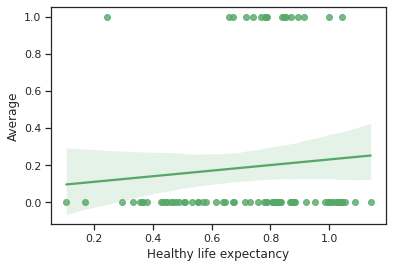

In [ ]:
import seaborn as sns
plot1 = sns.regplot(x="Healthy life expectancy", y= y_train.iloc[:,0], data=X_train, color='g')

From the first plot we can find out there are positive relationship between 'Health Life Expectancy' and 'Average Life Evaluation'. When the 'Health Life Expectancy'increases, 'Average Life Evaluation' will increase.

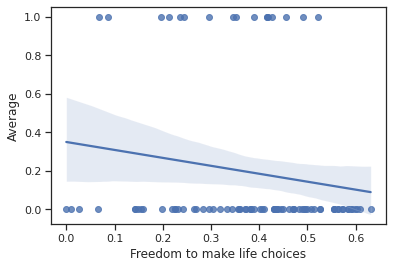

In [ ]:
plot2= sns.regplot(x="Freedom to make life choices", y= y_train.iloc[:,0], data=X_train, color='b')

From the second plot, we can find out there are negative relationship between 'Freedom to make life choices' and 'Average Life Evaluation'. When'Freedom to make life choices' increase, 'Average Life Evaluation' will decrease.

## Q2. Examine features that predict happiness categories using one or more models that allow for automatic feature selection

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
x = X_train.iloc[:,1:7]
y = y_train.iloc[:,0]

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(x, y)

SelectFromModel(estimator=RandomForestClassifier())

In [ ]:
selected_feat= x.columns[(sel.get_support())]
len(selected_feat)

3

In [ ]:
print(selected_feat)

Index(['GDP per capita', 'Generosity', 'Perceptions of corruption'], dtype='object')


I use Random Forest Classifier to select features, 'GDP per capita', 'Generosity', and 'Perceptions of corruption' are automatically selected.

## Q3.Experiment with different prediction models to try to predict World Happiness well (Fit and compare, at minimum, three models)

## Before discussion

### Model 1: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'n_estimators': np.arange(100, 300, 500),'max_depth':[1, 3, 5]} #np.arange creates sequence of numbers for each k value

gridmodel = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=10)

#use meta model methods to fit score and predict model:
gridmodel.fit(preprocessor(X_train), y_train_labels)

#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(gridmodel.best_score_))
print("best parameters: {}".format(gridmodel.best_params_))

best mean cross-validation score: 0.669
best parameters: {'max_depth': 5, 'n_estimators': 100}


In [ ]:
model_1 = RandomForestClassifier(n_estimators=100, max_depth=5)
model_1.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model_1.score(preprocessor(X_train), y_train_labels)

0.9545454545454546

In [ ]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there?
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model_1, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials

#This is the unique rest api that powers this World Happiness Classification Playground -- make sure to update the apiurl for new competition deployments
apiurl="https://e2w6gh3id1.execute-api.us-east-2.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [ ]:
#Submit Model 1: 

#-- Generate predicted values (Model 1)
prediction_labels = model_1.predict(preprocessor(X_test))

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels, custom_metadata={"team":"1"})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 817

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


## Model 2: Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid_2 = {'n_estimators': np.arange(100, 300, 500),'max_depth':[1, 3, 5]} #np.arange creates sequence of numbers for each k value

gridmodel_2 = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=10)

#use meta model methods to fit score and predict model:
gridmodel_2.fit(preprocessor(X_train), y_train_labels)

#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(gridmodel_2.best_score_))
print("best parameters: {}".format(gridmodel_2.best_params_))


best mean cross-validation score: 0.626
best parameters: {'max_depth': 1, 'n_estimators': 100}


In [ ]:
model_2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(preprocessor(X_train), y_train_labels)
model_2.score(preprocessor(X_train), y_train_labels)

1.0

In [ ]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(model_2, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#-- Generate predicted values 
prediction_labels = model_2.predict(preprocessor(X_test))

In [ ]:
# Submit model to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels, custom_metadata={"team":"1"})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 818

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


## Model 3: Deep Learning

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

feature_count=preprocessor(X_train).shape[1] #count features in input data

keras_model = Sequential()
keras_model.add(Dense(128, input_dim=feature_count, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(32, activation='relu'))

keras_model.add(Dense(5, activation='softmax')) 
                                            
# Compile model
keras_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
keras_model.fit(preprocessor(X_train), y_train, ## Note that keras models require a one-hot-encoded y_train object
               batch_size = 20, 
               epochs = 300, validation_split=0.25)  

Epoch 1/300
4/4 [==============================] - 1s 74ms/step - loss: 1.5801 - accuracy: 0.2879 - val_loss: 1.5905 - val_accuracy: 0.2273
Epoch 2/300
4/4 [==============================] - 0s 15ms/step - loss: 1.5671 - accuracy: 0.3333 - val_loss: 1.5835 - val_accuracy: 0.2273
Epoch 3/300
4/4 [==============================] - 0s 16ms/step - loss: 1.5561 - accuracy: 0.3333 - val_loss: 1.5753 - val_accuracy: 0.2273
Epoch 4/300
4/4 [==============================] - 0s 13ms/step - loss: 1.5428 - accuracy: 0.3485 - val_loss: 1.5682 - val_accuracy: 0.2273
Epoch 5/300
4/4 [==============================] - 0s 18ms/step - loss: 1.5323 - accuracy: 0.3636 - val_loss: 1.5610 - val_accuracy: 0.2727
Epoch 6/300
4/4 [==============================] - 0s 12ms/step - loss: 1.5199 - accuracy: 0.3939 - val_loss: 1.5556 - val_accuracy: 0.2273
Epoch 7/300
4/4 [==============================] - 0s 11ms/step - loss: 1.5074 - accuracy: 0.4697 - val_loss: 1.5491 - val_accuracy: 0.2727
Epoch 8/300
4/4 [===

In [ ]:
# Save keras model to ONNX file 

from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(keras_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
# Submit keras model: 

#-- Generate predicted y values
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=keras_model.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels, custom_metadata={"team":"1"})


3/3 [==============================] - 0s 4ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 819

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


## After Discussion

### Model 4

In [ ]:
model_4 = RandomForestClassifier(n_estimators=200, max_depth=5)
model_4.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model_4.score(preprocessor(X_train), y_train_labels)

0.9545454545454546

In [ ]:
#-- Generate predicted values (Model 4)
prediction_labels = model_4.predict(preprocessor(X_test))

# Submit Model 4 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,custom_metadata={"team":"1"})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 836

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


### Model 5

In [ ]:
model_5 = GradientBoostingClassifier(n_estimators=9, learning_rate=1.0,
    max_depth=1, random_state=0).fit(preprocessor(X_train), y_train_labels)
model_5.score(preprocessor(X_train), y_train_labels)

0.9659090909090909

In [ ]:
#-- Generate predicted values 
prediction_labels = model_5.predict(preprocessor(X_test))

In [ ]:
# Submit model to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels, custom_metadata={"team":"1"})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 827

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


### Model 6

In [ ]:
feature_count=preprocessor(X_train).shape[1] #count features in input data

keras_model = Sequential()
keras_model.add(Dense(128, input_dim=feature_count, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(64, activation='relu'))

keras_model.add(Dense(5, activation='softmax')) 
                                            
# Compile model
keras_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
keras_model.fit(preprocessor(X_train), y_train, ## Note that keras models require a one-hot-encoded y_train object
               batch_size = 20, 
               epochs = 300, validation_split=0.25)  

Epoch 1/300
4/4 [==============================] - 1s 67ms/step - loss: 1.6024 - accuracy: 0.1818 - val_loss: 1.6003 - val_accuracy: 0.2727
Epoch 2/300
4/4 [==============================] - 0s 12ms/step - loss: 1.5910 - accuracy: 0.1970 - val_loss: 1.5949 - val_accuracy: 0.2727
Epoch 3/300
4/4 [==============================] - 0s 12ms/step - loss: 1.5808 - accuracy: 0.2576 - val_loss: 1.5909 - val_accuracy: 0.1364
Epoch 4/300
4/4 [==============================] - 0s 20ms/step - loss: 1.5703 - accuracy: 0.2576 - val_loss: 1.5871 - val_accuracy: 0.2273
Epoch 5/300
4/4 [==============================] - 0s 12ms/step - loss: 1.5615 - accuracy: 0.3333 - val_loss: 1.5834 - val_accuracy: 0.2273
Epoch 6/300
4/4 [==============================] - 0s 14ms/step - loss: 1.5529 - accuracy: 0.3636 - val_loss: 1.5792 - val_accuracy: 0.1364
Epoch 7/300
4/4 [==============================] - 0s 11ms/step - loss: 1.5430 - accuracy: 0.3788 - val_loss: 1.5745 - val_accuracy: 0.1364
Epoch 8/300
4/4 [===

In [ ]:
# Save keras model to ONNX file 

from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(keras_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
# Submit keras model: 

#-- Generate predicted y values
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=keras_model.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels, custom_metadata={"team":"1"})

3/3 [==============================] - 0s 4ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 832

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


Gradient Boosting Classifier Model perform the best, the relevant hyper parameters are max_depth=1 and n_estimators=100

Link to GitHub Repo: https://github.com/Estelleccc/ml-project-steps/tree/main/Homework